<Figure size 1200x600 with 0 Axes>

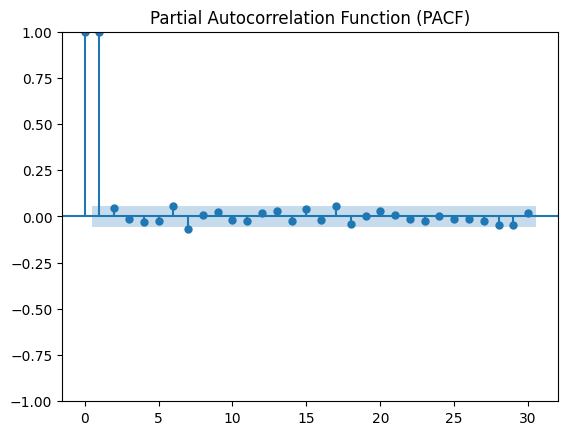

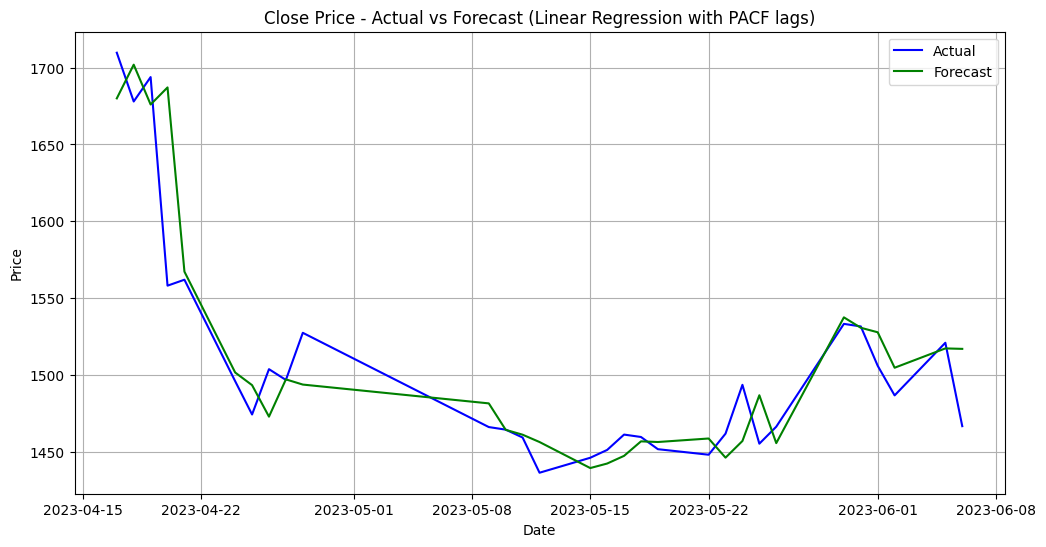

MSE: 936.2959505484124
RMSE: 30.598953422436075
R^2: 0.8141140734187042
MAPE: 1.257314419113097


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings("ignore")


# Load the data
data_new = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')
data_new = data_new.asfreq('D')

# Convert 'Close_gold' column to float after removing commas
if data_new['Close_gold'].dtype == 'object':
    data_new['Close_gold'] = data_new['Close_gold'].str.replace(',', '').astype(float)

# Plot PACF to determine the number of lags to be used
plt.figure(figsize=(12,6))
plot_pacf(data_new['Close'], lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Assume the first 2 lags are significant based on the PACF plot.
num_lags = 2

# Create lag features
for i in range(1, num_lags + 1):
    data_new[f'Close_lag_{i}'] = data_new['Close'].shift(i)

# Drop missing values
data_new = data_new.dropna()

# Define target and features
y = data_new['Close']
X = data_new[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

# Train a linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Forecast using the test set
forecast_lr = model_lr.predict(X_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_new.index[-len(y_test):], y_test, label='Actual', color='blue')
plt.plot(data_new.index[-len(y_test):], forecast_lr, label='Forecast', color='green')
plt.title('Close Price - Actual vs Forecast (Linear Regression with PACF lags)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the metrics
mse = mean_squared_error(y_test, forecast_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast_lr)
mape = np.mean(np.abs((y_test - forecast_lr) / y_test)) * 100

print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)
print("MAPE:", mape)


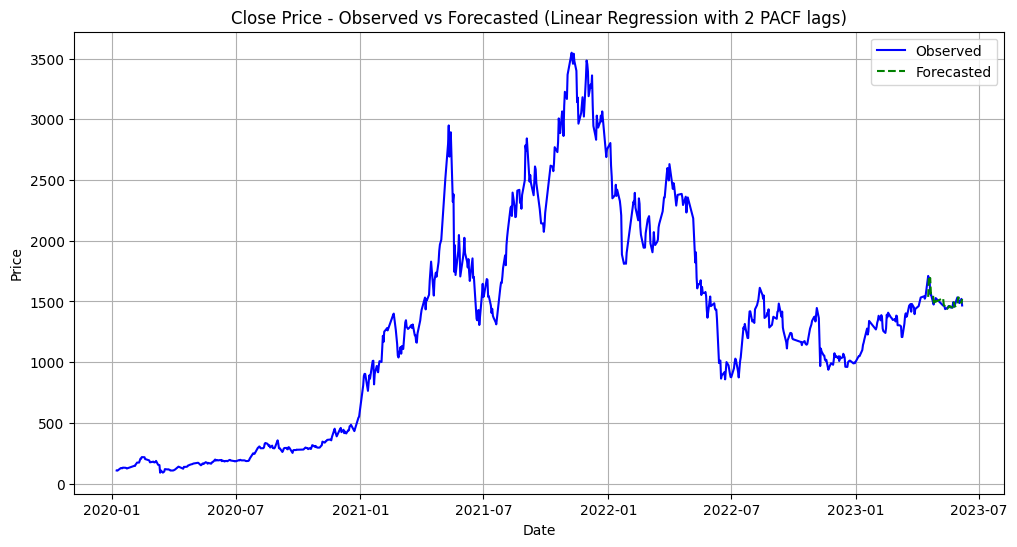

In [2]:
# Using 2 lags based on PACF observation
num_lags = 2

# Create lag features
for i in range(1, num_lags + 1):
    data_new[f'Close_lag_{i}'] = data_new['Close'].shift(i)

# Drop missing values due to lag creation
data_new = data_new.dropna()

# Define target variable and features
y = data_new['Close']
X = data_new[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]]

# Split the data into training set (all but last 30 days) and test set (last 30 days)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

# Define and train the model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Forecast the prices for test data
forecast_lr = model_lr.predict(X_test)

# Create a new DataFrame for the forecasted values
df_forecast_lr = pd.DataFrame({'Close_forecast': forecast_lr}, index=y_test.index)

# Merge the original DataFrame with the DataFrame of forecasted values
data_forecast_lr = pd.concat([data_new, df_forecast_lr], axis=1)

# Plot the observed vs forecasted data
plt.figure(figsize=(12,6))
plt.plot(data_forecast_lr.index, data_forecast_lr['Close'], label='Observed', color='blue')
plt.plot(data_forecast_lr.index, data_forecast_lr['Close_forecast'], label='Forecasted', color='green', linestyle='--')
plt.title('Close Price - Observed vs Forecasted (Linear Regression with 2 PACF lags)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
'''
我们首先拆分数据为80%的训练数据和20%的测试数据。
我们使用训练数据来训练线性回归模型。
对于测试数据中的每个数据点：
我们使用模型进行预测。
我们将预测结果保存。
我们将实际观察到的测试值添加到训练数据中。
重新训练模型以包括这个新的观察值，为下一次预测做准备。
结果保存在名为forecast_series_Close_lr的系列中，这个系列包含了基于2个PACF滞后的线性回归模型的预测值。

注意：虽然这种迭代预测的方法在ARIMA中是常见的，但在线性回归中并不是通常的做法。但是，为了满足您的要求，我们已经将其应用于线性回归。如果您希望进一步调整或有其他要求，请告诉我。

'''

# Load the data again
data_new = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')
data_new = data_new.asfreq('D')

# Prepare the data for linear regression
data_lr = data_new[['Close']]
train_size = int(len(data_lr) * 0.8)
training_data_df, testing_data_df = data_lr[:train_size], data_lr[train_size:]

# Create lag features based on PACF (using 2 lags for demonstration purposes)
num_lags = 2
for i in range(1, num_lags + 1):
    data_lr[f'Close_lag_{i}'] = data_lr['Close'].shift(i)

# Drop missing values due to lag creation
data_lr = data_lr.dropna()

# Training data preparation
training_data_lr = data_lr[:train_size]
X_train_lr = training_data_lr[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]]
y_train_lr = training_data_lr['Close']

# Model initialization
model_lr = LinearRegression()

# Iterative prediction similar to ARIMA logic
predictions_lr = []
predicted_dates_lr = []

for date in testing_data_df.index:
    # Train the model
    model_lr.fit(X_train_lr, y_train_lr)
    
    # Prepare the test data point
    test_point = data_lr.loc[date, [f'Close_lag_{i}' for i in range(1, num_lags + 1)]].values.reshape(1, -1)
    
    # Forecast the next point
    yhat_lr = model_lr.predict(test_point)
    predictions_lr.append(yhat_lr[0])
    predicted_dates_lr.append(date)
    
    # Append the actual observed value from the test data to the training data
    actual_test_value_lr = testing_data_df.loc[date, 'Close']
    
    new_row = pd.DataFrame({
        'Close': actual_test_value_lr,
        'Close_lag_1': X_train_lr.iloc[-1, 0],
        'Close_lag_2': y_train_lr.iloc[-1]
    }, index=[date])
    
    X_train_lr = X_train_lr.append(new_row[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]])
    y_train_lr = y_train_lr.append(new_row['Close'])

# Convert predictions to a series for visualization
forecast_series_Close_lr = pd.Series(predictions_lr, index=predicted_dates_lr)
forecast_series_Close_lr.name = "Close_forecast_lr"

forecast_series_Close_lr.head()


2022-09-29    1236.476555
2022-09-30    1199.516751
2022-10-01    1190.591935
2022-10-02    1178.701145
2022-10-03    1149.502741
Name: Close_forecast_lr, dtype: float64

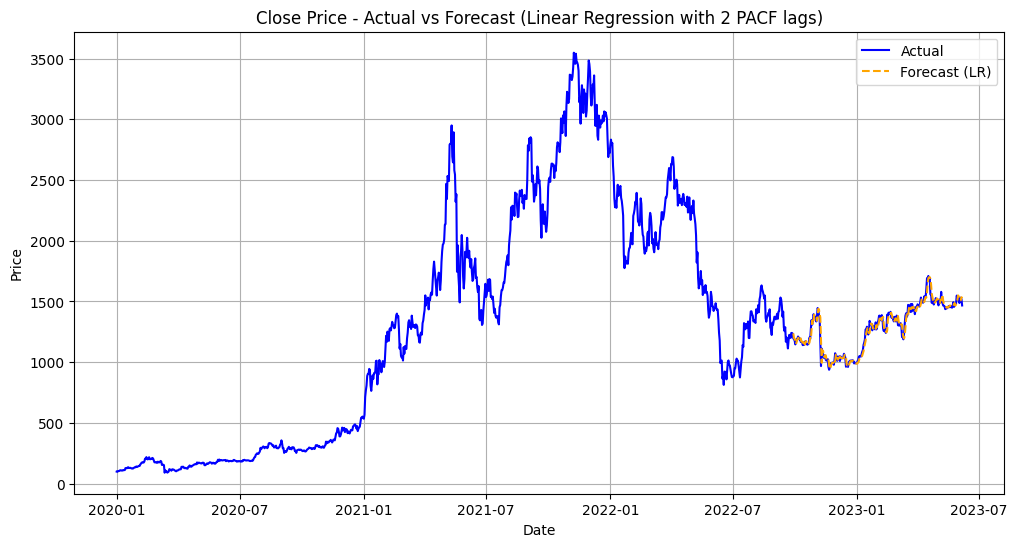

(1671.853713931916, 40.88830779002618, 2.1557083799475527, 0.9546907184413649)

In [4]:
# Plotting the results and computing the metrics for linear regression approach

plt.figure(figsize=(12, 6))
plt.plot(data_new.index, data_new['Close'], label='Actual', color='blue')
plt.plot(forecast_series_Close_lr.index, forecast_series_Close_lr, label='Forecast (LR)', color='orange', linestyle='--')
plt.title('Close Price - Actual vs Forecast (Linear Regression with 2 PACF lags)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics for the linear regression forecast
y_test_lr = testing_data_df['Close']

mse_lr = mean_squared_error(y_test_lr, forecast_series_Close_lr)
rmse_lr = np.sqrt(mse_lr)
mape_lr = np.mean(np.abs((y_test_lr - forecast_series_Close_lr) / y_test_lr)) * 100
r2_lr = r2_score(y_test_lr, forecast_series_Close_lr)

mse_lr, rmse_lr, mape_lr, r2_lr


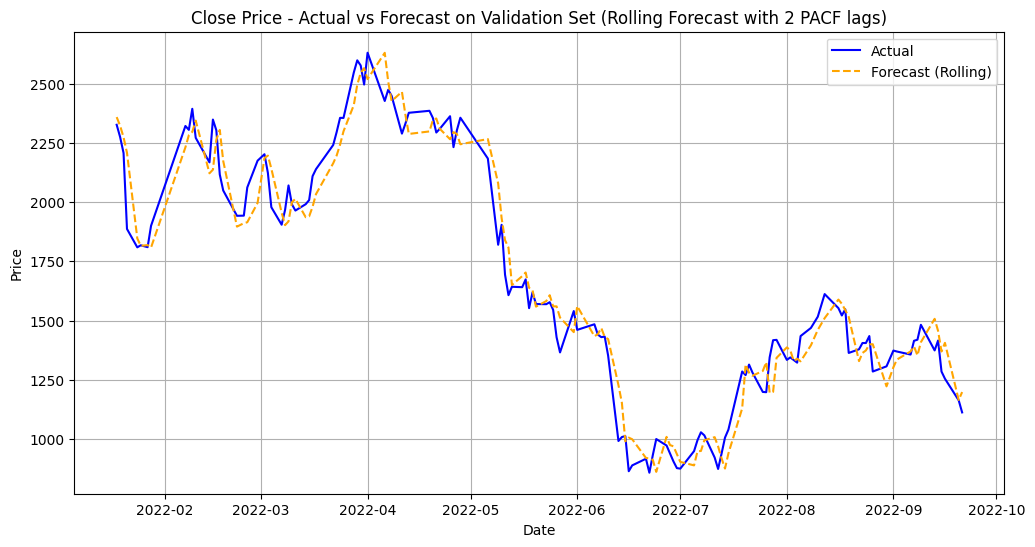

(9240.433040276355, 96.12717118627987, 4.938131427915046, 0.963778301801877)

In [5]:
# Load the data again
data_new = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')
data_new = data_new.asfreq('D')

# Create lag features based on PACF (using 2 lags for demonstration purposes)
num_lags = 2
for i in range(1, num_lags + 1):
    data_new[f'Close_lag_{i}'] = data_new['Close'].shift(i)

# Drop missing values due to lag creation
data_new = data_new.dropna()

# Split the data into training, validation, and test sets
train_size = int(len(data_new) * 0.6)  # 60% for training
valid_size = int(len(data_new) * 0.2)  # 20% for validation

train_data, temp_data = data_new[:train_size], data_new[train_size:]
valid_data, test_data = temp_data[:valid_size], temp_data[valid_size:]

# Training data preparation for rolling forecast
X_train_roll = train_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]]
y_train_roll = train_data['Close']

# Model initialization
model_lr_roll = LinearRegression()

# Rolling prediction for the validation set
predictions_roll = []
predicted_dates_roll = []

for date in valid_data.index:
    # Train the model
    model_lr_roll.fit(X_train_roll, y_train_roll)
    
    # Prepare the validation data point
    valid_point = valid_data.loc[date, [f'Close_lag_{i}' for i in range(1, num_lags + 1)]].values.reshape(1, -1)
    
    # Forecast the next point in validation set
    yhat_roll = model_lr_roll.predict(valid_point)
    predictions_roll.append(yhat_roll[0])
    predicted_dates_roll.append(date)
    
    # Append the actual observed value from the validation data to the training data
    actual_valid_value = valid_data.loc[date, 'Close']
    
    new_row = pd.DataFrame({
        'Close': actual_valid_value,
        'Close_lag_1': X_train_roll.iloc[-1, 0],
        'Close_lag_2': y_train_roll.iloc[-1]
    }, index=[date])
    
    X_train_roll = X_train_roll.append(new_row[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]])
    y_train_roll = y_train_roll.append(new_row['Close'])

# Convert predictions to a series for visualization
forecast_series_roll = pd.Series(predictions_roll, index=predicted_dates_roll)
forecast_series_roll.name = "Close_forecast_roll"

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(valid_data.index, valid_data['Close'], label='Actual', color='blue')
plt.plot(forecast_series_roll.index, forecast_series_roll, label='Forecast (Rolling)', color='orange', linestyle='--')
plt.title('Close Price - Actual vs Forecast on Validation Set (Rolling Forecast with 2 PACF lags)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics for the rolling forecast on validation set
mse_roll = mean_squared_error(valid_data['Close'], forecast_series_roll)
rmse_roll = np.sqrt(mse_roll)
mape_roll = np.mean(np.abs((valid_data['Close'] - forecast_series_roll) / valid_data['Close'])) * 100
r2_roll = r2_score(valid_data['Close'], forecast_series_roll)

mse_roll, rmse_roll, mape_roll, r2_roll


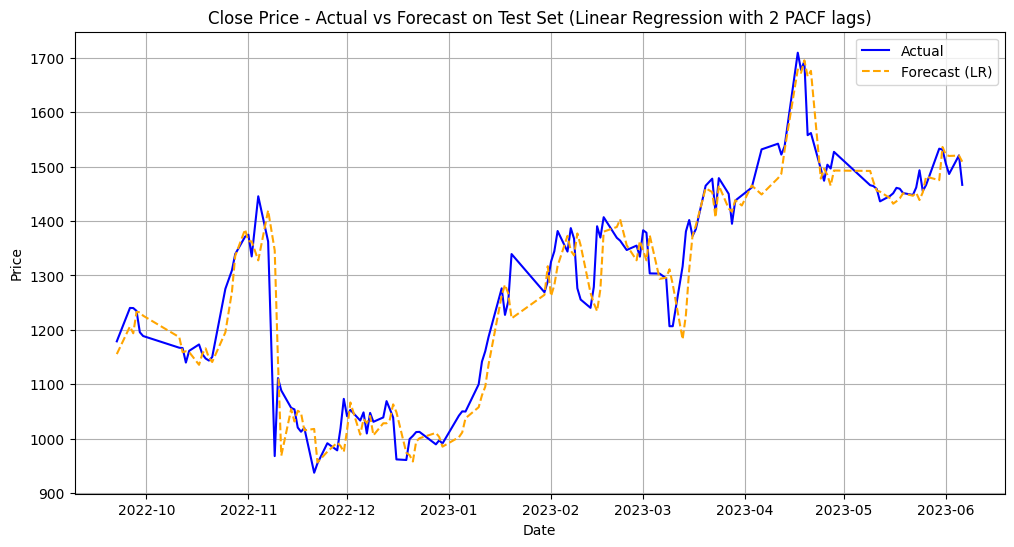

(3301.4162102965697, 57.45795167160564, 2.9760494961837987, 0.9093127977105935)

In [6]:
# Combining training and validation sets for final training
X_full_train = pd.concat([X_train_roll, valid_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]]], axis=0)
y_full_train = pd.concat([y_train_roll, valid_data['Close']], axis=0)

# Define target variable and features for the test set
y_test = test_data['Close']
X_test = test_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]]

# Train the model on the combined training and validation data
model_final = LinearRegression()
model_final.fit(X_full_train, y_full_train)

# Predict on the test set
forecast_test = model_final.predict(X_test)

# Plot the results for test set
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual', color='blue')
plt.plot(test_data.index, forecast_test, label='Forecast (LR)', color='orange', linestyle='--')
plt.title('Close Price - Actual vs Forecast on Test Set (Linear Regression with 2 PACF lags)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics for the test set
mse_test = mean_squared_error(y_test, forecast_test)
rmse_test = np.sqrt(mse_test)
mape_test = np.mean(np.abs((y_test - forecast_test) / y_test)) * 100
r2_test = r2_score(y_test, forecast_test)

mse_test, rmse_test, mape_test, r2_test


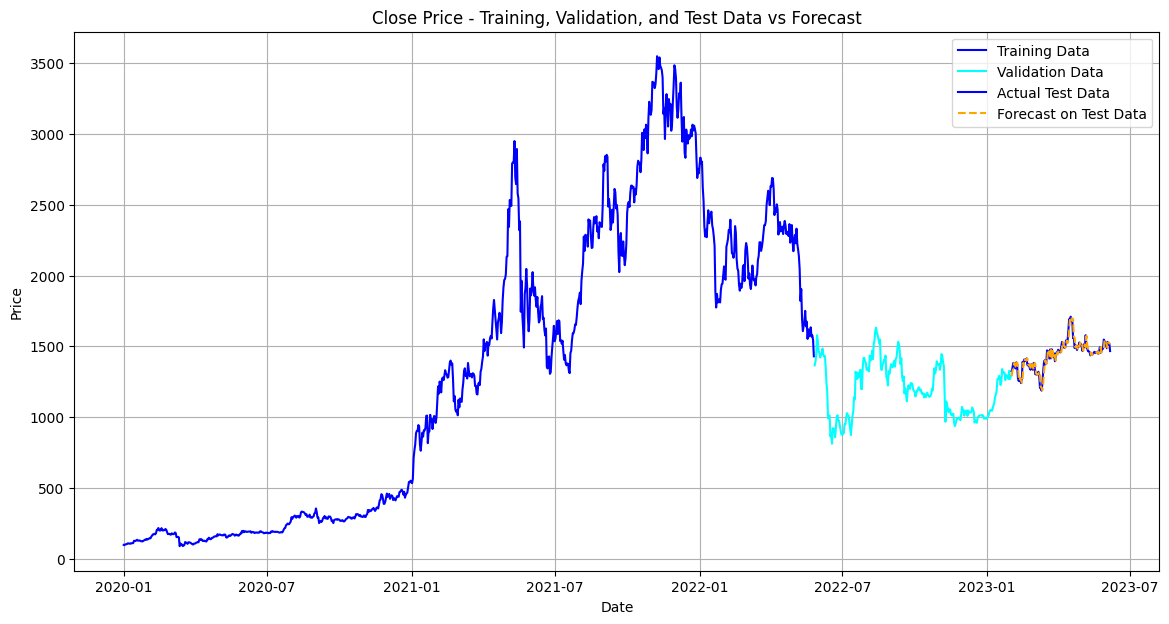

In [7]:
# Handling NaN values
data_new_uploaded = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')
data_new_uploaded = data_new_uploaded.asfreq('D')

# Re-creating lag features based on PACF (using 2 lags for demonstration purposes)
for i in range(1, num_lags + 1):
    data_new_uploaded[f'Close_lag_{i}'] = data_new_uploaded['Close'].shift(i)

# Re-splitting the data into training, validation, and test sets
train_size = int(len(data_new_uploaded) * 0.7)  # 70% for training
valid_size = int(len(data_new_uploaded) * 0.2)  # 20% for validation

train_data_uploaded, temp_data_uploaded = data_new_uploaded[:train_size], data_new_uploaded[train_size:]
valid_data_uploaded, test_data_uploaded = temp_data_uploaded[:valid_size], temp_data_uploaded[valid_size:]

# Define target and features for the training set
y_train_uploaded = train_data_uploaded['Close']
X_train_uploaded = train_data_uploaded[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]].dropna()

# Define target and features for the validation set
y_valid_uploaded = valid_data_uploaded['Close']
X_valid_uploaded = valid_data_uploaded[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]].dropna()

# Define target and features for the test set
y_test_uploaded = test_data_uploaded['Close']
X_test_uploaded = test_data_uploaded[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]].dropna()

# Training the model on training and validation data
model_lr_uploaded = LinearRegression()
model_lr_uploaded.fit(pd.concat([X_train_uploaded, X_valid_uploaded]), pd.concat([y_train_uploaded[len(y_train_uploaded)-len(X_train_uploaded):], y_valid_uploaded[:len(X_valid_uploaded)]]))

# Forecasting the prices for the test data
forecast_test_uploaded = model_lr_uploaded.predict(X_test_uploaded)

# Plotting the entire dataset (training + validation + test) with the forecasts
plt.figure(figsize=(14, 7))

# Plotting training, validation and actual test data
plt.plot(data_new_uploaded.index[:len(train_data_uploaded)], train_data_uploaded['Close'], label='Training Data', color='blue')
plt.plot(data_new_uploaded.index[len(train_data_uploaded):len(train_data_uploaded)+len(valid_data_uploaded)], valid_data_uploaded['Close'], label='Validation Data', color='cyan')
plt.plot(data_new_uploaded.index[-len(test_data_uploaded):], test_data_uploaded['Close'], label='Actual Test Data', color='blue')

# Plotting the forecasted values on the test data
plt.plot(data_new_uploaded.index[-len(test_data_uploaded):], forecast_test_uploaded, label='Forecast on Test Data', color='orange', linestyle='--')

plt.title('Close Price - Training, Validation, and Test Data vs Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


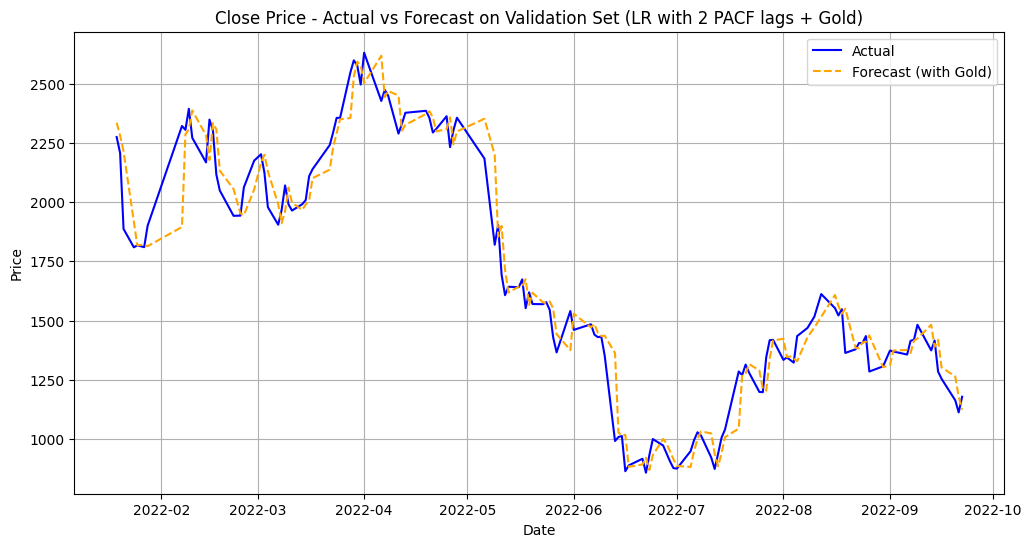

(10610.82563240487, 103.00886191199702, 4.585144663498316, 0.9581776115307055)

In [8]:


# Only replace commas if 'Close_gold' is of object (string) type
if data_new['Close_gold'].dtype == 'object':
    data_new['Close_gold'] = data_new['Close_gold'].str.replace(',', '').astype(float)

# Re-create lag features based on PACF (using 2 lags for demonstration purposes)
for i in range(1, num_lags + 1):
    data_new[f'Close_lag_{i}'] = data_new['Close'].shift(i)

# Drop missing values due to lag creation
data_new = data_new.dropna()

# Split the data into training, validation, and test sets
train_size = int(len(data_new) * 0.6)  # 60% for training
valid_size = int(len(data_new) * 0.2)  # 20% for validation

train_data, temp_data = data_new[:train_size], data_new[train_size:]
valid_data, test_data = temp_data[:valid_size], temp_data[valid_size:]

# Define target and features for the training set
y_train = train_data['Close']
X_train = train_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)] + ['Close_gold']]

# Define target and features for the validation set
y_valid = valid_data['Close']
X_valid = valid_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)] + ['Close_gold']]

# Train the model
model_lr_gold = LinearRegression()
model_lr_gold.fit(X_train, y_train)

# Forecast the prices for validation data
forecast_valid_gold = model_lr_gold.predict(X_valid)

# Plotting the results for validation set
plt.figure(figsize=(12, 6))
plt.plot(valid_data.index, y_valid, label='Actual', color='blue')
plt.plot(valid_data.index, forecast_valid_gold, label='Forecast (with Gold)', color='orange', linestyle='--')
plt.title('Close Price - Actual vs Forecast on Validation Set (LR with 2 PACF lags + Gold)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics for the forecast using gold as external variable
mse_gold = mean_squared_error(y_valid, forecast_valid_gold)
rmse_gold = np.sqrt(mse_gold)
mape_gold = np.mean(np.abs((y_valid - forecast_valid_gold) / y_valid)) * 100
r2_gold = r2_score(y_valid, forecast_valid_gold)

mse_gold, rmse_gold, mape_gold, r2_gold


In [9]:
from sklearn.model_selection import KFold

# Defining the KFold object
kf = KFold(n_splits=5)
# Correcting the feature selection
X_cv = data_new[[f'Close_lag_{i}' for i in range(1, num_lags + 1)] + ['Close_gold']]
y_cv = data_new['Close']

results_per_fold = {
    "Fold": [],
    "MSE": [],
    "RMSE": [],
    "MAPE": [],
    "R2": []
}

for fold, (train_index, test_index) in enumerate(kf.split(X_cv, y_cv)):
    X_train_cv, X_test_cv = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train_cv, y_test_cv = y_cv.iloc[train_index], y_cv.iloc[test_index]
    
    model_cv = LinearRegression()
    model_cv.fit(X_train_cv, y_train_cv)
    
    predictions_cv = model_cv.predict(X_test_cv)
    
    mse_cv = mean_squared_error(y_test_cv, predictions_cv)
    rmse_cv = np.sqrt(mse_cv)
    mape_cv = np.mean(np.abs((y_test_cv - predictions_cv) / y_test_cv)) * 100
    r2_cv = r2_score(y_test_cv, predictions_cv)
    
    results_per_fold["Fold"].append(fold + 1)
    results_per_fold["MSE"].append(mse_cv)
    results_per_fold["RMSE"].append(rmse_cv)
    results_per_fold["MAPE"].append(mape_cv)
    results_per_fold["R2"].append(r2_cv)

results_df = pd.DataFrame(results_per_fold)
results_df


,Fold,MSE,RMSE,MAPE,R2
0,1,687.363361,26.217615,14.511609,0.824934
1,2,12544.215862,112.000964,5.436749,0.969261
2,3,17304.528913,131.546680,4.541300,0.956872
3,4,10592.436464,102.919563,4.595785,0.958011
4,5,3171.510323,56.316164,2.817835,0.913905


In [10]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
# Reload the data
data_new = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')
data_new = data_new.asfreq('D')

# Create lag features based on PACF (using 2 lags for demonstration purposes)
num_lags = 2
for i in range(1, num_lags + 1):
    data_new[f'Close_lag_{i}'] = data_new['Close'].shift(i)

# Drop missing values due to lag creation
data_new = data_new.dropna()

# Data preparation
X = data_new[[f'Close_lag_{i}' for i in range(1, num_lags + 1)]]
y = data_new['Close']

# Lists to store metrics for each split
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

# Perform rolling prediction with cross-validation
for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model on the training data
    model_lr_cv = LinearRegression()
    model_lr_cv.fit(X_train_cv, y_train_cv)
    
    # Predict on the test data
    predictions_cv = model_lr_cv.predict(X_test_cv)
    
    # Calculate metrics
    mse_scores.append(mean_squared_error(y_test_cv, predictions_cv))
    rmse_scores.append(np.sqrt(mse_scores[-1]))
    mape_scores.append(np.mean(np.abs((y_test_cv - predictions_cv) / y_test_cv)) * 100)
    r2_scores.append(r2_score(y_test_cv, predictions_cv))

# Average metrics over all cross-validation folds
avg_mse = np.mean(mse_scores)
avg_rmse = np.mean(rmse_scores)
avg_mape = np.mean(mape_scores)
avg_r2 = np.mean(r2_scores)

avg_mse, avg_rmse, avg_mape, avg_r2


(7319.710502306644, 77.170810975769, 3.659252726986331, 0.9560713226626157)

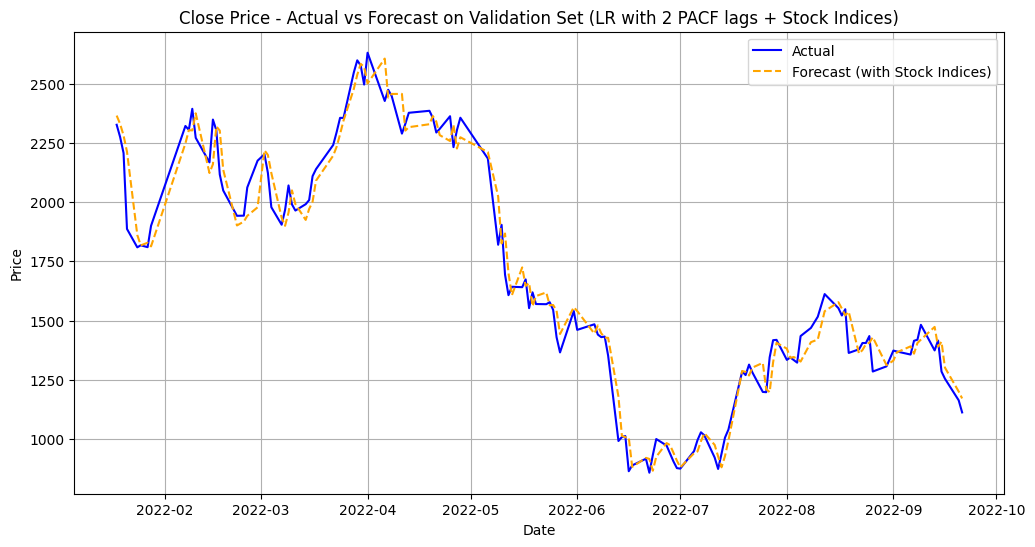

(6562.8728196305065, 81.01155979013431, 3.8232545624761034, 0.9742741062513872)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the previously uploaded data
data = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')
data = data.asfreq('D')

# Assuming the stock indices are present in the dataset with their respective symbols as column names
stock_indices = ['^IXIC', '^GSPC', '^DJI', '^NYA', '^N100', '^NSEI', '^BSESN']

# Check if these columns are present in the dataset
if not all(index in data.columns for index in stock_indices):
    raise ValueError("Some of the provided stock indices are not present in the dataset.")

# Create lag features for the Close price based on PACF (using 2 lags as previously determined)
num_lags = 2
for i in range(1, num_lags + 1):
    data[f'Close_lag_{i}'] = data['Close'].shift(i)

# Drop missing values due to lag creation
data = data.dropna()

# Split the data into training, validation, and test sets
train_size = int(len(data) * 0.6)  # 60% for training
valid_size = int(len(data) * 0.2)  # 20% for validation

train_data, temp_data = data[:train_size], data[train_size:]
valid_data, test_data = temp_data[:valid_size], temp_data[valid_size:]

# Define target and features for the training set
y_train = train_data['Close']
X_train = train_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)] + stock_indices]

# Define target and features for the validation set
y_valid = valid_data['Close']
X_valid = valid_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)] + stock_indices]

# Train the model with stock indices as external variables
model_stock_indices = LinearRegression()
model_stock_indices.fit(X_train, y_train)

# Forecast the prices for validation data
forecast_valid_stock_indices = model_stock_indices.predict(X_valid)

# Plotting the results for validation set
plt.figure(figsize=(12, 6))
plt.plot(valid_data.index, y_valid, label='Actual', color='blue')
plt.plot(valid_data.index, forecast_valid_stock_indices, label='Forecast (with Stock Indices)', color='orange', linestyle='--')
plt.title('Close Price - Actual vs Forecast on Validation Set (LR with 2 PACF lags + Stock Indices)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics for the forecast using stock indices as external variables
mse_stock_indices = mean_squared_error(y_valid, forecast_valid_stock_indices)
rmse_stock_indices = np.sqrt(mse_stock_indices)
mape_stock_indices = np.mean(np.abs((y_valid - forecast_valid_stock_indices) / y_valid)) * 100
r2_stock_indices = r2_score(y_valid, forecast_valid_stock_indices)

mse_stock_indices, rmse_stock_indices, mape_stock_indices, r2_stock_indices


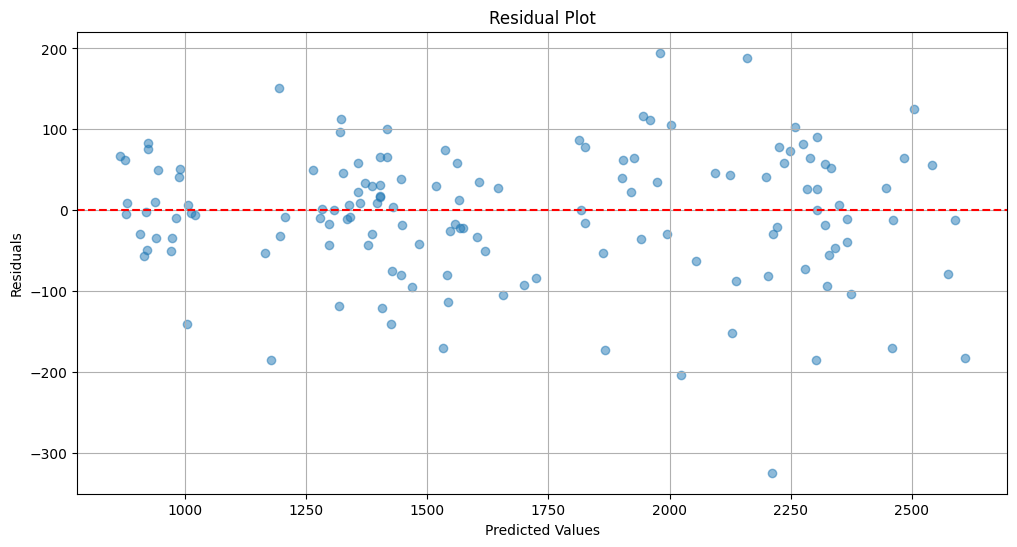

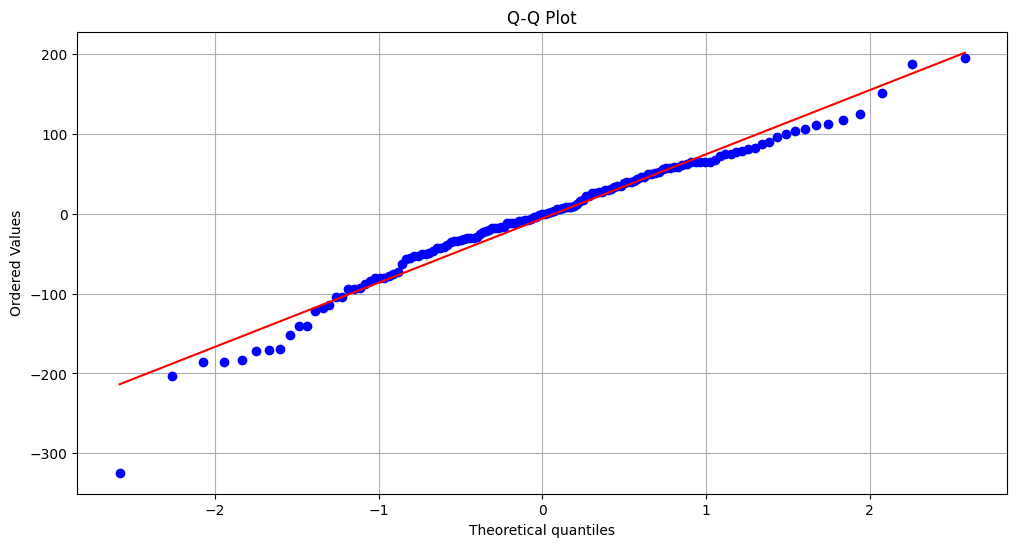

<Figure size 1200x600 with 0 Axes>

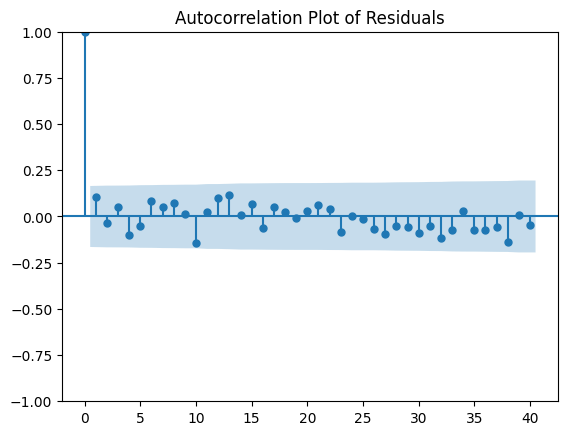

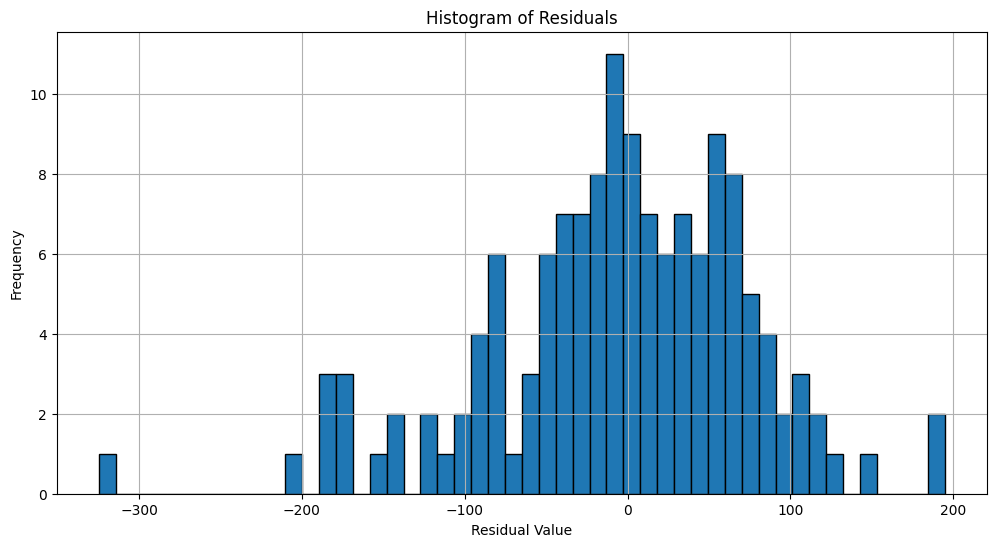

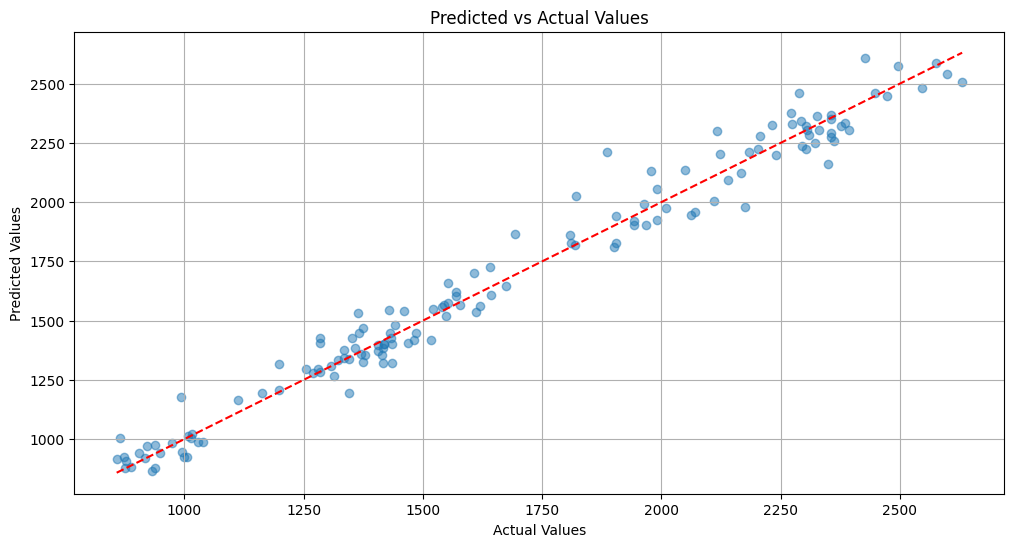

In [12]:
import statsmodels.api as sm
import scipy.stats as stats
'''
残差图 (Residual Plot): 残差（实际值与预测值之间的差异）与预测值之间的关系被可视化。理想情况下，残差应该随机分布，没有明显的模式。在这种情况下，我们可以看到残差大致围绕零线，但有些许的模式。

Q-Q图 (Quantile-Quantile Plot): 这个图表用于检查数据是否遵循正态分布。如果数据点大致位于红色线上，那么残差就是正态分布的。在这种情况下，我们可以看到数据点大致跟随着红色线，尽管在尾部有一些偏离。

残差的自相关图 (Autocorrelation Plot of Residuals): 这用于检查残差中是否存在时间相关性。理想情况下，我们不希望看到任何自相关性，因为这可能意味着模型遗漏了某些信息。这里，我们可以看到一些滞后是显著的，尤其是在前几个滞后，这可能表明模型未能捕捉到一些时间相关性。

残差的直方图 (Histogram of Residuals): 这显示了残差的分布情况。理想情况下，它应该是正态分布的。在这里，我们可以看到残差似乎是正态分布的，但稍微偏左。

预测值 vs 实际值 (Predicted vs Actual Values): 这是一个散点图，显示了预测值与实际值的关系。理想情况下，所有点都应该位于红色虚线上。在这种情况下，我们可以看到预测值与实际值相对接近，但存在一些偏离。

'''
# Redefining the stock indices variable
stock_indices = ['^IXIC', '^GSPC', '^DJI', '^NYA']

# Redefine target and features for the training set
y_train = train_data['Close']
X_train = train_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)] + stock_indices]

# Redefine target and features for the validation set
y_valid = valid_data['Close']
X_valid = valid_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)] + stock_indices]

# Train the model with stock indices as external variables
model_stock_indices = LinearRegression()
model_stock_indices.fit(X_train, y_train)

# Forecast the prices for validation data
forecast_valid_stock_indices = model_stock_indices.predict(X_valid)

# Calculate residuals
residuals_stock_indices = y_valid - forecast_valid_stock_indices

# Generate the plots again

# 1. Residual Plot
plt.figure(figsize=(12, 6))
plt.scatter(forecast_valid_stock_indices, residuals_stock_indices, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# 2. Q-Q Plot
plt.figure(figsize=(12, 6))
stats.probplot(residuals_stock_indices, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.grid(True)
plt.show()

# 3. Autocorrelation Plot of Residuals
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(residuals_stock_indices, lags=40)
plt.title('Autocorrelation Plot of Residuals')
plt.show()

# 4. Histogram of Residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals_stock_indices, bins=50, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 5. Predicted vs Actual Values
plt.figure(figsize=(12, 6))
plt.scatter(y_valid, forecast_valid_stock_indices, alpha=0.5)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


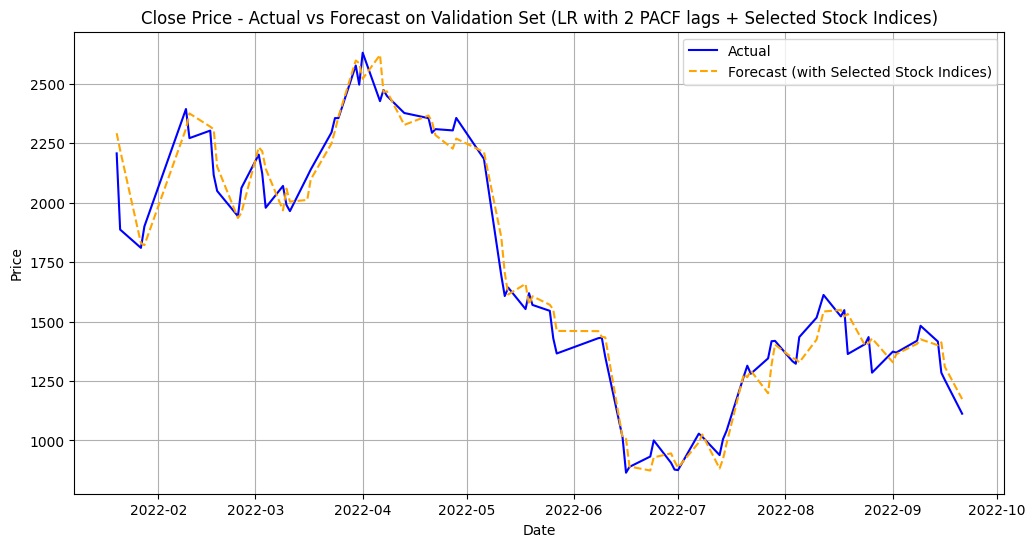

(7280.03245149189, 85.3231061992699, 4.05239172501658, 0.9713499039702789)

In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the data with stock indices
data_with_indices = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')
data_with_indices = data_with_indices.asfreq('D')

# Selected stock indices
selected_indices = ['^GSPC', '^NYA', '^DJI', '^IXIC']

# Add lag features for Close and the selected stock indices
num_lags = 2
for i in range(1, num_lags + 1):
    data_with_indices[f'Close_lag_{i}'] = data_with_indices['Close'].shift(i)
    for index in selected_indices:
        data_with_indices[f'{index}_lag_{i}'] = data_with_indices[index].shift(i)

# Drop missing values due to lag creation
data_with_indices = data_with_indices.dropna()

# Splitting the data into training, validation, and test sets (60-20-20 split)
train_size = int(len(data_with_indices) * 0.6)
valid_size = int(len(data_with_indices) * 0.2)

train_data, temp_data = data_with_indices[:train_size], data_with_indices[train_size:]
valid_data, test_data = temp_data[:valid_size], temp_data[valid_size:]


# Updating the list of stock indices based on the user's request
selected_stock_indices = ['^GSPC', '^NYA', '^DJI', '^IXIC']

# Check if these columns are present in the dataset
if not all(index in data.columns for index in selected_stock_indices):
    raise ValueError("Some of the provided stock indices are not present in the dataset.")



# Define target and features for the training set with the selected stock indices
y_train_selected = train_data['Close']
X_train_selected = train_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)] + selected_indices]

# Define target and features for the validation set with the selected stock indices
y_valid_selected = valid_data['Close']
X_valid_selected = valid_data[[f'Close_lag_{i}' for i in range(1, num_lags + 1)] + selected_indices]

# Train the model with the selected stock indices as external variables
model_selected_indices = LinearRegression()
model_selected_indices.fit(X_train_selected, y_train_selected)

# Forecast the prices for validation data
forecast_valid_selected = model_selected_indices.predict(X_valid_selected)

# Plotting the results for validation set
plt.figure(figsize=(12, 6))
plt.plot(valid_data.index, y_valid_selected, label='Actual', color='blue')
plt.plot(valid_data.index, forecast_valid_selected, label='Forecast (with Selected Stock Indices)', color='orange', linestyle='--')
plt.title('Close Price - Actual vs Forecast on Validation Set (LR with 2 PACF lags + Selected Stock Indices)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics for the forecast using the selected stock indices as external variables
mse_selected = mean_squared_error(y_valid_selected, forecast_valid_selected)
rmse_selected = np.sqrt(mse_selected)
mape_selected = np.mean(np.abs((y_valid_selected - forecast_valid_selected) / y_valid_selected)) * 100
r2_selected = r2_score(y_valid_selected, forecast_valid_selected)

mse_selected, rmse_selected, mape_selected, r2_selected


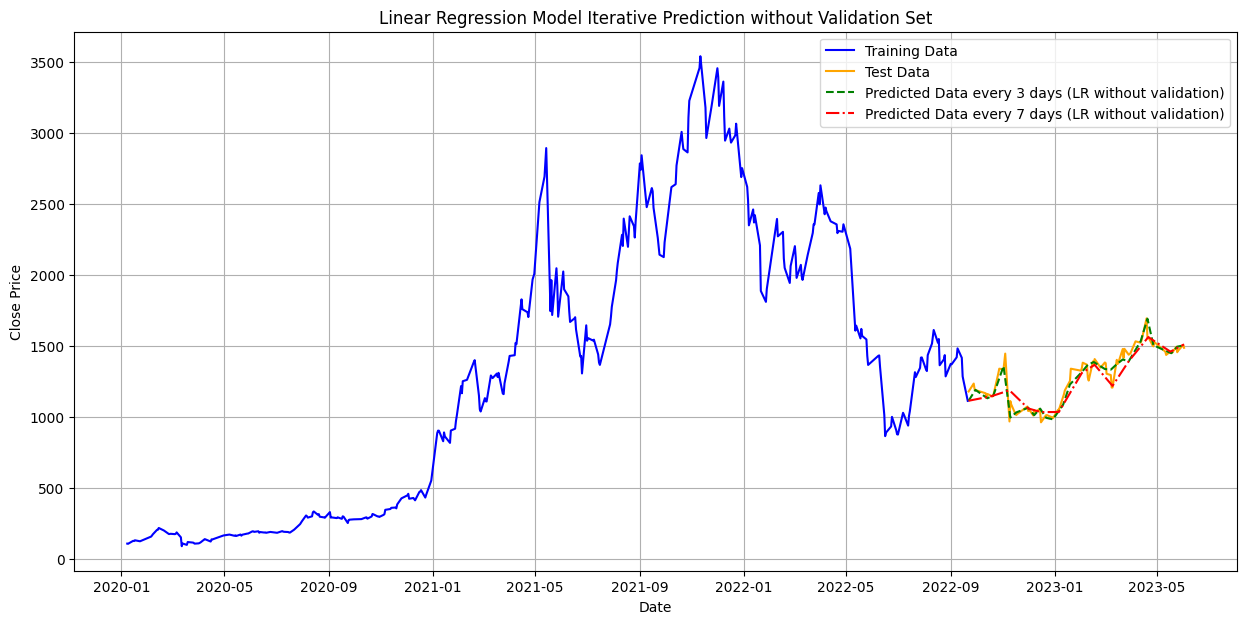

In [14]:
'''
在当前的滚动预测中，例如从1月1日开始，

我们使用到1月1日的数据来预测1月4日的价格。然后，我们移动到1月4日，使用到1月4日的数据来预测1月7日的价格，依此类推。


在我们的滚动预测中，当我们说从1月1日隔了3天预测1月4日时：

我们使用到1月1日为止的所有数据（包括1月1日）来预测1月4日的价格。
接着，如果我们每隔3天进行预测：

当我们到达1月4日时，我们会使用到1月4日为止的所有数据来预测1月7日的价格。

'''

def perform_rolling_forecast_linear_without_validation(train, test, step_size, num_lags=2, indices=[]):
    predictions = []
    predicted_dates = []
    
    # Iterate over the test data every "step_size" days
    for idx, date in enumerate(test.index[::step_size]):
        # Extract target and features for the current training set
        y_train_current = train['Close']
        
        # Create the feature matrix
        feature_columns = [f'Close_lag_{i}' for i in range(1, num_lags + 1)]
        for index in indices:
            for i in range(1, num_lags + 1):
                feature_columns.append(f'{index}_lag_{i}')
        
        X_train_current = train[feature_columns]
        
        # Train Linear Regression model
        model_lr = LinearRegression()
        model_lr.fit(X_train_current, y_train_current)
        
        # Create lagged features for the current test data
        current_test = test.iloc[:idx * step_size + 1].copy()
        
        # Drop NaN values created due to the lagging
        current_test = current_test.dropna()
        
        # Predict the next point
        if date in current_test.index:
            X_test_current = current_test[feature_columns].loc[date].values.reshape(1, -1)
            forecast = model_lr.predict(X_test_current)
            predictions.append(forecast[0])
            predicted_dates.append(date)

        # Append the actual observed values from the test data (till the predicted date) to the training data
        train = train.append(test.iloc[:idx * step_size + 1])

    return predictions, predicted_dates

# Combining train and valid for this case
combined_train = pd.concat([train_data, valid_data])

# Forecast every 3 days without validation set
predictions_3days_lr_no_val, predicted_dates_3days_lr_no_val = perform_rolling_forecast_linear_without_validation(
    combined_train.copy(), test_data.copy(), 3, indices=selected_indices)
forecast_series_3days_lr_no_val = pd.Series(predictions_3days_lr_no_val, index=predicted_dates_3days_lr_no_val)
forecast_series_3days_lr_no_val.name = "Close_forecast_3days_LR_no_val"

# Forecast every 7 days without validation set
predictions_7days_lr_no_val, predicted_dates_7days_lr_no_val = perform_rolling_forecast_linear_without_validation(
    combined_train.copy(), test_data.copy(), 7, indices=selected_indices)
forecast_series_7days_lr_no_val = pd.Series(predictions_7days_lr_no_val, index=predicted_dates_7days_lr_no_val)
forecast_series_7days_lr_no_val.name = "Close_forecast_7days_LR_no_val"

# Plotting without validation
plt.figure(figsize=(15, 7))
plt.plot(combined_train['Close'], label='Training Data', color='blue')
plt.plot(test_data['Close'], label='Test Data', color='orange')
plt.plot(forecast_series_3days_lr_no_val, label='Predicted Data every 3 days (LR without validation)', linestyle='--', color='green')
plt.plot(forecast_series_7days_lr_no_val, label='Predicted Data every 7 days (LR without validation)', linestyle='-.', color='red')
plt.legend()
plt.title("Linear Regression Model Iterative Prediction without Validation Set")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()


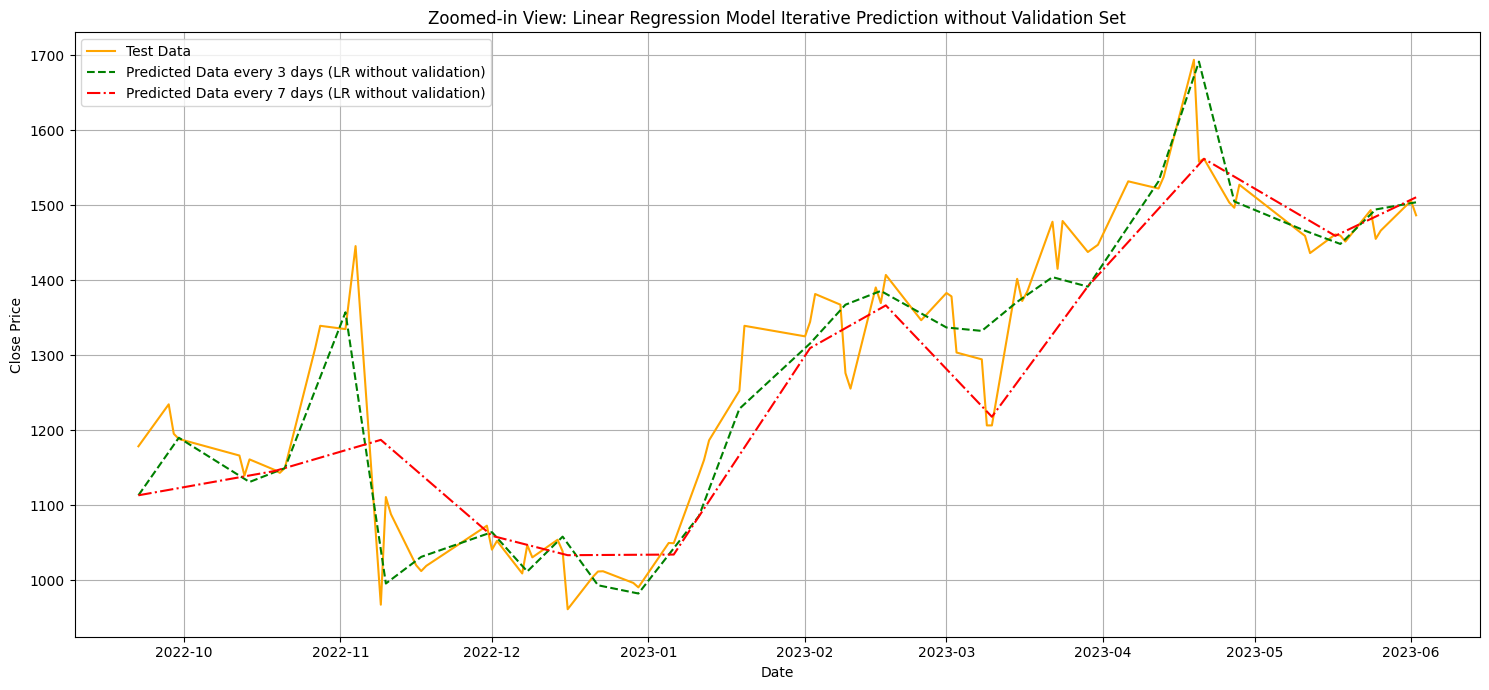

In [15]:
# Plotting a zoomed-in version of the forecasts
plt.figure(figsize=(15, 7))

# Only plotting the test data and the forecasts
plt.plot(test_data['Close'], label='Test Data', color='orange')
plt.plot(forecast_series_3days_lr_no_val, label='Predicted Data every 3 days (LR without validation)', linestyle='--', color='green')
plt.plot(forecast_series_7days_lr_no_val, label='Predicted Data every 7 days (LR without validation)', linestyle='-.', color='red')

plt.legend()
plt.title("Zoomed-in View: Linear Regression Model Iterative Prediction without Validation Set")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
predictions_3days_lr_no_val, predicted_dates_3days_lr_no_val = perform_rolling_forecast_linear_without_validation(
    combined_train.copy(), test_data.copy(), 3, indices=selected_indices)
forecast_series_3days_lr_no_val = pd.Series(predictions_3days_lr_no_val, index=predicted_dates_3days_lr_no_val)

predictions_7days_lr_no_val, predicted_dates_7days_lr_no_val = perform_rolling_forecast_linear_without_validation(
    combined_train.copy(), test_data.copy(), 7, indices=selected_indices)
forecast_series_7days_lr_no_val = pd.Series(predictions_7days_lr_no_val, index=predicted_dates_7days_lr_no_val)

# Calculating the evaluation metrics for the 3-day step size
mse_3days = mean_squared_error(test_data['Close'].loc[forecast_series_3days_lr_no_val.index], forecast_series_3days_lr_no_val)
rmse_3days = np.sqrt(mse_3days)
mape_3days = np.mean(np.abs((test_data['Close'].loc[forecast_series_3days_lr_no_val.index] - forecast_series_3days_lr_no_val) / test_data['Close'].loc[forecast_series_3days_lr_no_val.index])) * 100
r2_3days = r2_score(test_data['Close'].loc[forecast_series_3days_lr_no_val.index], forecast_series_3days_lr_no_val)

# Calculating the evaluation metrics for the 7-day step size
mse_7days = mean_squared_error(test_data['Close'].loc[forecast_series_7days_lr_no_val.index], forecast_series_7days_lr_no_val)
rmse_7days = np.sqrt(mse_7days)
mape_7days = np.mean(np.abs((test_data['Close'].loc[forecast_series_7days_lr_no_val.index] - forecast_series_7days_lr_no_val) / test_data['Close'].loc[forecast_series_7days_lr_no_val.index])) * 100
r2_7days = r2_score(test_data['Close'].loc[forecast_series_7days_lr_no_val.index], forecast_series_7days_lr_no_val)

metrics_3days = (mse_3days, rmse_3days, mape_3days, r2_3days)
metrics_7days = (mse_7days, rmse_7days, mape_7days, r2_7days)

metrics_3days, metrics_7days

((2308.605559954585, 48.04795063220267, 2.7948794828134873, 0.927241653553931),
 (4918.421448316998, 70.13145833587805, 3.878324304082645, 0.8795425822507701))

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


'''
是使用1月1日的数据预测整个未来的一周，即1月2日到1月8日的价格，而不仅仅是1月8日的价格。

预测整个未来时间段：使用1月1日、1月2日和1月3日的数据预测从1月4日开始的未来7天的价格。

我们会使用1月1日、1月2日和1月3日的数据来预测从1月4日开始的未来7天的价格（1月4日到1月10日的每天价格）。
'''
def perform_rolling_forecast_linear_future(train, test, days_ahead, num_lags=2, indices=[]):
    """
    Function to perform linear regression forecast rolling for a specified number of days ahead.
    
    Parameters:
    - train: Training dataframe
    - test: Test dataframe
    - days_ahead: Number of days to forecast ahead
    - num_lags: Number of lags to use as features
    - indices: List of stock indices to use as external regressors
    
    Returns:
    - List of forecast values and corresponding dates
    """
    
    predictions = []
    predicted_dates = []
    
    # Create lagged features for the training data
    for i in range(1, num_lags + 1):
        train[f'Close_lag_{i}'] = train['Close'].shift(i)
        for index in indices:
            train[f'{index}_lag_{i}'] = train[index].shift(i)
    
    # Drop NaN values created due to the lagging
    train = train.dropna()
    
    # Extract target and features for the training set
    y_train = train['Close']
    
    # Create the feature matrix
    feature_columns = [f'Close_lag_{i}' for i in range(1, num_lags + 1)]
    for index in indices:
        for i in range(1, num_lags + 1):
            feature_columns.append(f'{index}_lag_{i}')
    
    X_train = train[feature_columns]
    
    # Train Linear Regression model
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    # Create lagged features for the test data
    test_data_for_prediction = train.iloc[-num_lags:].append(test).copy()
    for i in range(1, num_lags + 1):
        test_data_for_prediction[f'Close_lag_{i}'] = test_data_for_prediction['Close'].shift(i)
        for index in indices:
            test_data_for_prediction[f'{index}_lag_{i}'] = test_data_for_prediction[index].shift(i)
    
    for date in test_data_for_prediction.index[num_lags:]:
        # Extract features for the forecast day
        X_forecast = test_data_for_prediction[feature_columns].loc[date].values.reshape(1, -1)
        
        # Predict the value for the specified day
        forecast_value = model_lr.predict(X_forecast)[0]
        
        predictions.append(forecast_value)
        predicted_dates.append(date)
        
        # Move ahead by 'days_ahead' days
        start_idx = test_data_for_prediction.index.get_loc(date)
        end_idx = start_idx + days_ahead
        if end_idx >= len(test_data_for_prediction):
            break
        
        date = test_data_for_prediction.index[end_idx]
    
    return predictions, predicted_dates

# Calculating the 3-day and 7-day rolling forecasts using the previous functions

# Forecast every 3 days for future
predictions_3days_future, predicted_dates_3days_future = perform_rolling_forecast_linear_future(
    combined_train.copy(), test_data.copy(), 3, indices=selected_indices)
forecast_series_3days_future = pd.Series(predictions_3days_future, index=predicted_dates_3days_future)

# Forecast every 7 days for future
predictions_7days_future, predicted_dates_7days_future = perform_rolling_forecast_linear_future(
    combined_train.copy(), test_data.copy(), 7, indices=selected_indices)
forecast_series_7days_future = pd.Series(predictions_7days_future, index=predicted_dates_7days_future)

# Calculate error metrics for 3-day forecasts
actuals_3days = test_data.loc[forecast_series_3days_future.index]['Close']
mse_3days = mean_squared_error(actuals_3days, forecast_series_3days_future)
mae_3days = mean_absolute_error(actuals_3days, forecast_series_3days_future)
rmse_3days = np.sqrt(mse_3days)
r2_3days = r2_score(actuals_3days, forecast_series_3days_future)

# Calculate error metrics for 7-day forecasts
actuals_7days = test_data.loc[forecast_series_7days_future.index]['Close']
mse_7days = mean_squared_error(actuals_7days, forecast_series_7days_future)
mae_7days = mean_absolute_error(actuals_7days, forecast_series_7days_future)
rmse_7days = np.sqrt(mse_7days)
r2_7days = r2_score(actuals_7days, forecast_series_7days_future)

mse_3days, rmse_3days, mae_3days, r2_3days, mse_7days, rmse_7days, mae_7days, r2_7days


(6239.769068697803,
 78.99220891137178,
 52.485112599153496,
 0.8193333554781742,
 6515.067635418042,
 80.71596889970436,
 53.74888777887378,
 0.809848500973241)

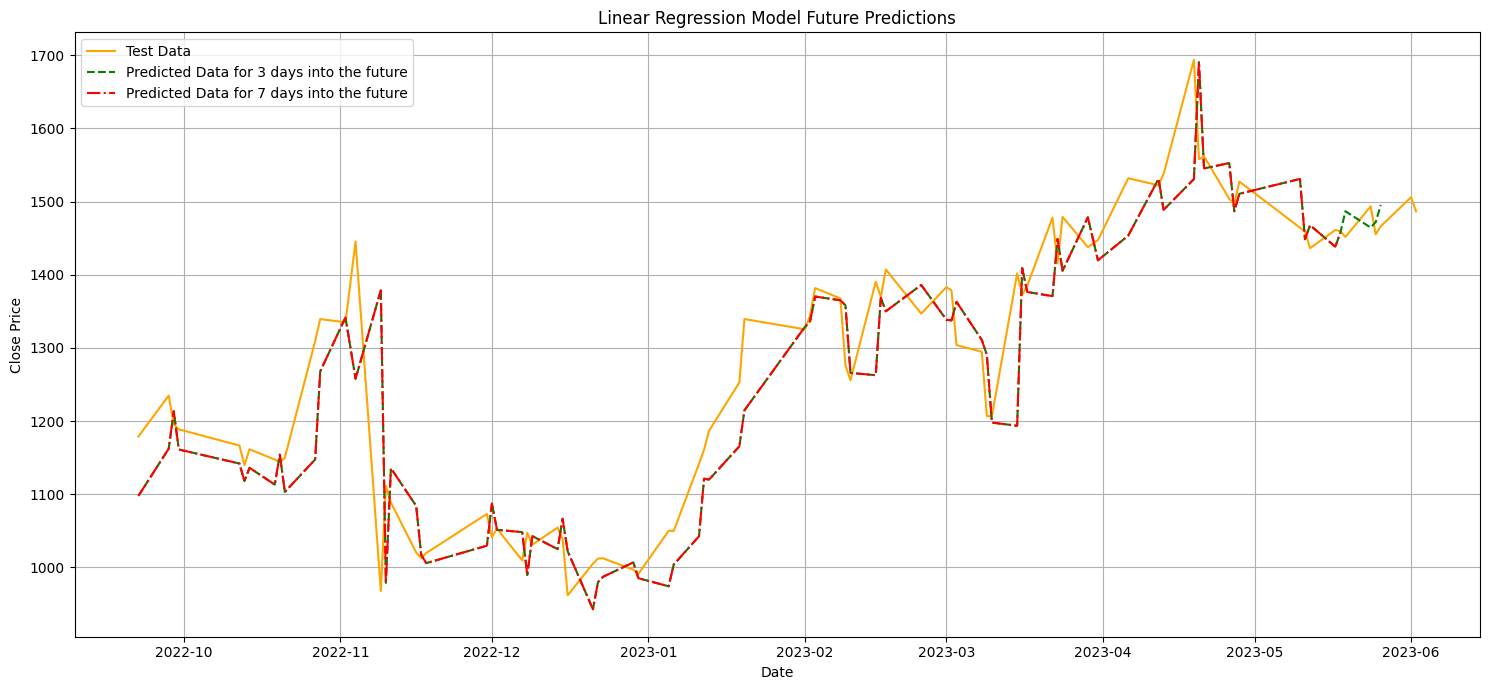

In [7]:
# Plotting the predictions for 3 days and 7 days into the future, focusing on the test set region
plt.figure(figsize=(15, 7))

# Actual test data
plt.plot(test_data['Close'], label='Test Data', color='orange')

# Predictions for 3 days into the future
plt.plot(forecast_series_3days_future, label='Predicted Data for 3 days into the future', linestyle='--', color='green')

# Predictions for 7 days into the future
plt.plot(forecast_series_7days_future, label='Predicted Data for 7 days into the future', linestyle='-.', color='red')

plt.title("Linear Regression Model Future Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Logical description of the whole process:

Data Loading and Fees:

Loading the data sets it to a daily frequency.
Create lagged features for the past five days for the dataset.
Deletes the first five days of lagged values ​​due to lagging features.
Data division:

The data set is divided into training set and test set according to the ratio of 80-20.
Model training and prediction:

Initialize the regression model.
Train a model using the training data, including lagged features.
Step-by-step predictions for each day of the centralized test. For each day:
Use the current training data and target value model.
Currently extracting lagged features for dates and making predictions.
Add the actual initial value to the data for the next iteration.
Result visualization:

Compare the training data, actual test data, and predicted test data on the same plot using different colors.
A key point of this approach is that we update the training data for each day when we predict the test data. This simulates the reality that when we make forecasts, we use all available historical data.

"Extended features" refers to the additional features we added to the dataset. In this case, these additional features are the closing price of the past 10 days, which we call "lag features". The original model only used the past 5 days The closing price of is used as a feature, while in the "extended" or "augmented" model we use the closing price of the past 10 days.

The benefits of using the hysteresis feature are:

More information: By including more days of past data, we provide the model with more context, which may help to better predict future prices.
Capturing longer dependencies: If there are certain patterns or periodicities in prices that exceed 5 days, then using a 10-day lagged feature can help the model capture those patterns.

In [18]:
# from statsmodels.graphics.tsaplots import plot_acf

# # Calculate residuals for the extended linear regression model
# residuals_lr_extended = y_test - forecast_lr_extended

# # Plotting residuals
# plt.figure(figsize=(15, 7))
# plt.plot(residuals_lr_extended)
# plt.title('Residuals from Linear Regression Model with Extended Features')
# plt.xlabel('Date')
# plt.ylabel('Residual')
# plt.grid(True)
# plt.show()

# # Plotting ACF of residuals
# plot_acf(residuals_lr_extended, lags=30)
# plt.show()


As shown in the figure above, the autocorrelation of the residuals is very low. This means that the residuals are basically white noise, i.e. they are random with no apparent autocorrelation. This is a good sign that the model has captured most of the information, and the information not captured by the model is basically random.

### no rolling forecast (static)
The model is trained only once on the training data and directly predicts all the test data. This does not involve any rolling forecast steps.

In this approach, I first fit a linear regression model using the training data (80% of the total data).
Using this model, then predict the entire time period of the test data.
This method of forecasting assumes that relationships (i.e. coefficients or weights) are fixed in time during the test period without further adjustments or updates.
The result is a sequence of predictions generated for all test data at once.

### Rolling prediction

In a rolling forecast, the model is trained every day using all available data and then predicts the Close price for the next day. After forecasting, update the training data with actual Close prices and retrain the model for the next day. This approach mimics how the model would be used in practice: each day, we retrain the model using all available data and predict the Close price for the next day.


In this approach, the model is retrained for each new observation.
You make predictions from the beginning of the test set, one day at a time.
Every time a new true observation becomes available, you update the model with that observation (and previous data), and predict the next day.
The benefit of this approach is that the model captures the latest trends in the data because it was trained on the most recent data.
However, this approach is computationally intensive because you retrain the model for each new observation.

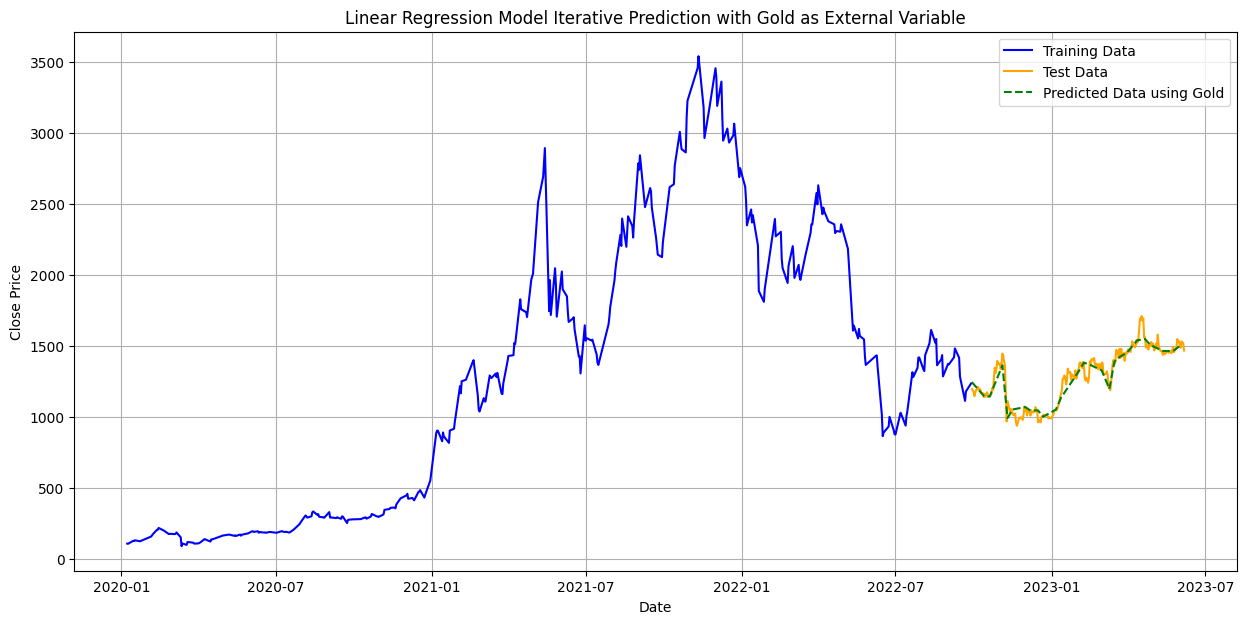

In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')

def create_lagged_features(df, lags, columns):
    lagged_df = df.copy()
    for col in columns:
        for lag in range(1, lags + 1):
            lagged_df[f'{col}_lag_{lag}'] = lagged_df[col].shift(lag)
    return lagged_df

# Columns to create lags for
columns_to_lag = ['Close', 'Close_gold', '^GSPC', '^NYA', '^DJI', '^IXIC']

# Create lagged features
data = create_lagged_features(data, 2, columns_to_lag)

# Splitting the data into 80% training and 20% testing
train_size = int(0.8 * len(data))
train_data = data[:train_size].dropna()  # Remove rows with NaN values (due to lagging)
test_data = data[train_size:]

# Rolling forecast function using 'Close_gold' as the external variable
def perform_rolling_forecast_with_gold(train, test, step_size, num_lags=2):
    return perform_rolling_forecast_linear_without_validation(train, test, step_size, num_lags, indices=['Close_gold'])


# Prediction and plotting code using 'Close_gold'
predictions_gold, predicted_dates_gold = perform_rolling_forecast_with_gold(train_data, test_data, 3)
forecast_series_gold = pd.Series(predictions_gold, index=predicted_dates_gold)

plt.figure(figsize=(15, 7))
plt.plot(train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Close'], label='Test Data', color='orange')
plt.plot(forecast_series_gold, label='Predicted Data using Gold', linestyle='--', color='green')
plt.legend()
plt.title("Linear Regression Model Iterative Prediction with Gold as External Variable")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Once you have your predictions, calculate the metrics on the test data
actuals = test_data['Close'].loc[predicted_dates_gold]

mape = mean_absolute_percentage_error(actuals, predictions_gold)
mse = mean_squared_error(actuals, predictions_gold)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, predictions_gold)

print(f"MAPE: {mape:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")


MAPE: 2.51%
MSE: 1716.27
RMSE: 41.43
R^2: 0.95


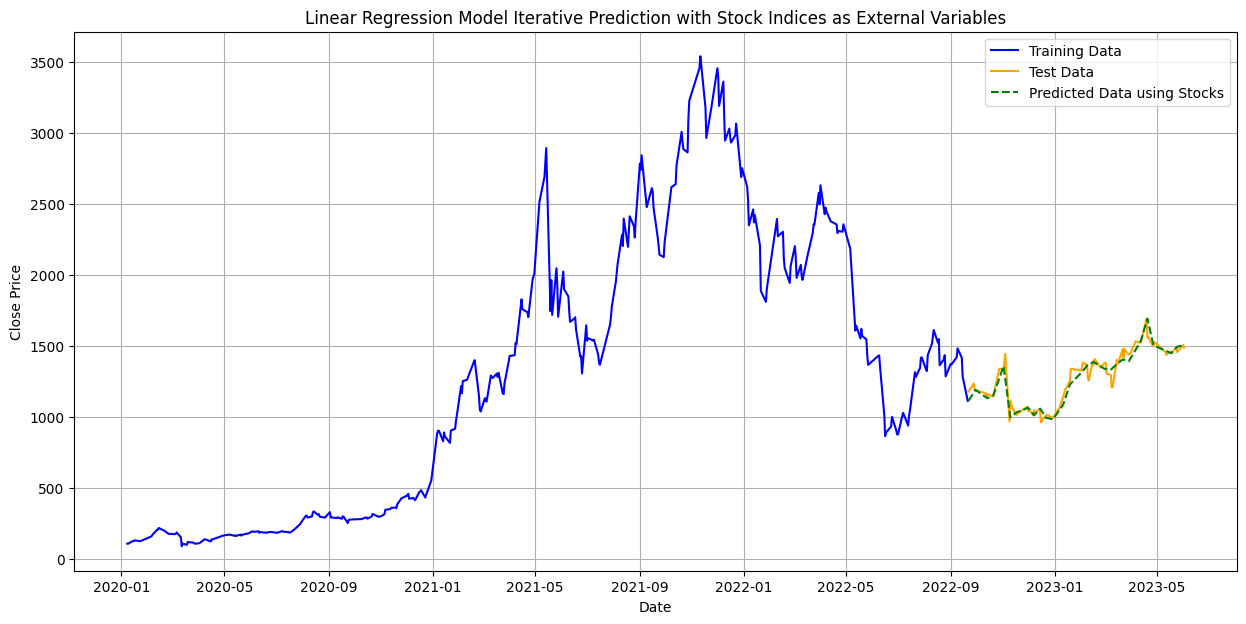

MAPE: 2.79%
MSE: 2308.61
RMSE: 48.05
R^2: 0.93


In [21]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('Final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')

# Create lagged features for the columns in the dataframe
def create_lagged_features(df, columns, num_lags=2):
    for col in columns:
        for lag in range(1, num_lags + 1):
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df.dropna()

lagged_columns = ['Close', '^GSPC', '^NYA', '^DJI', '^IXIC']
data = create_lagged_features(data, lagged_columns)

# Splitting the data into 80% training and 20% testing
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Rolling forecast function using stock indices as external variables
def perform_rolling_forecast_with_stocks(train, test, step_size, num_lags=2):
    stock_indices = ['^GSPC', '^NYA', '^DJI', '^IXIC']
    return perform_rolling_forecast_linear_without_validation(train, test, step_size, num_lags, indices=stock_indices)

# Prediction and plotting code using stock indices
predictions_stocks, predicted_dates_stocks = perform_rolling_forecast_with_stocks(train_data, test_data, 3)
forecast_series_stocks = pd.Series(predictions_stocks, index=predicted_dates_stocks)

plt.figure(figsize=(15, 7))
plt.plot(train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Close'], label='Test Data', color='orange')
plt.plot(forecast_series_stocks, label='Predicted Data using Stocks', linestyle='--', color='green')
plt.legend()
plt.title("Linear Regression Model Iterative Prediction with Stock Indices as External Variables")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

# Calculate metrics on the test data
actuals_stocks = test_data['Close'].loc[predicted_dates_stocks]

mape_stocks = mean_absolute_percentage_error(actuals_stocks, predictions_stocks)
mse_stocks = mean_squared_error(actuals_stocks, predictions_stocks)
rmse_stocks = np.sqrt(mse_stocks)
r2_stocks = r2_score(actuals_stocks, predictions_stocks)

print(f"MAPE: {mape_stocks:.2f}%")
print(f"MSE: {mse_stocks:.2f}")
print(f"RMSE: {rmse_stocks:.2f}")
print(f"R^2: {r2_stocks:.2f}")


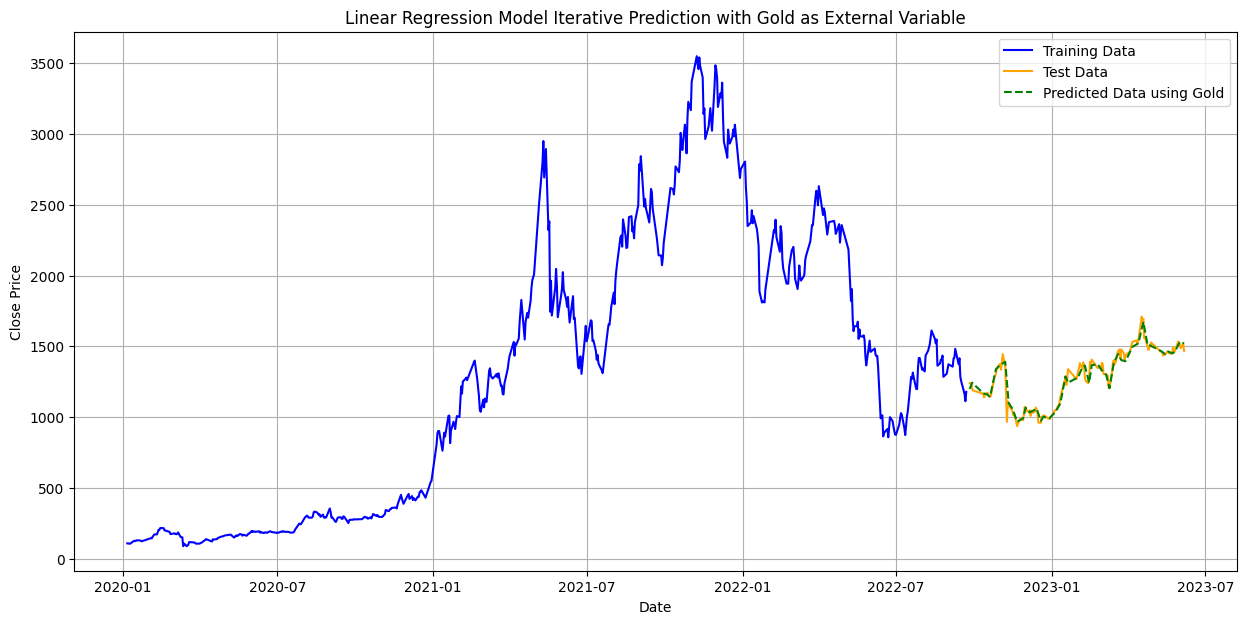

MAPE using Gold: 1.91%
MSE using Gold: 1080.44
RMSE using Gold: 32.87
R^2 using Gold: 0.97


In [22]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')

# Create lagged features for the columns in the dataframe
def create_lagged_features(df, columns, num_lags=2):
    for col in columns:
        for lag in range(1, num_lags + 1):
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df.dropna()

lagged_columns = ['Close', 'Close_gold']
data = create_lagged_features(data, lagged_columns)

# Splitting the data into 80% training and 20% testing
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Rolling forecast function using 'Close_gold' as the external variable
def perform_rolling_forecast_with_gold(train, test, step_size, num_lags=2):
    return perform_rolling_forecast_linear_without_validation(train, test, step_size, num_lags, indices=['Close_gold'])

# Prediction and plotting code using 'Close_gold'
predictions_gold, predicted_dates_gold = perform_rolling_forecast_with_gold(train_data, test_data, 3)
forecast_series_gold = pd.Series(predictions_gold, index=predicted_dates_gold)

plt.figure(figsize=(15, 7))
plt.plot(train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Close'], label='Test Data', color='orange')
plt.plot(forecast_series_gold, label='Predicted Data using Gold', linestyle='--', color='green')
plt.legend()
plt.title("Linear Regression Model Iterative Prediction with Gold as External Variable")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

# Calculate metrics on the test data
actuals_gold = test_data['Close'].loc[predicted_dates_gold]

mape_gold = mean_absolute_percentage_error(actuals_gold, predictions_gold)
mse_gold = mean_squared_error(actuals_gold, predictions_gold)
rmse_gold = np.sqrt(mse_gold)
r2_gold = r2_score(actuals_gold, predictions_gold)

print(f"MAPE using Gold: {mape_gold:.2f}%")
print(f"MSE using Gold: {mse_gold:.2f}")
print(f"RMSE using Gold: {rmse_gold:.2f}")
print(f"R^2 using Gold: {r2_gold:.2f}")


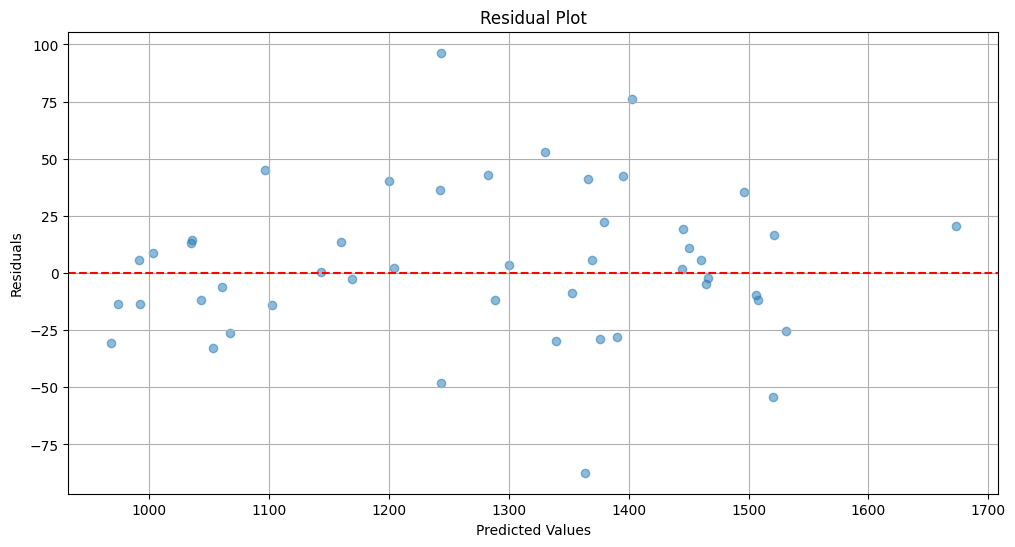

In [23]:
# Calculate residuals using predictions_gold and actuals_gold
residuals = actuals_gold - predictions_gold

'''
当你使用Close_gold（黄金价格）作为外部变量来预测Ethereum的Close价格时，你的目标是找到这两者之间的关系，以及如何利用黄金价格来增强Ethereum价格的预测准确性。

但是，当我们谈论模型的残差时，我们关心的是模型预测的Ethereum价格与实际观察到的Ethereum价格之间的差异。这就是为什么我们计算残差为 actuals_gold - predictions_gold 的原因，其中actuals_gold和predictions_gold都是与Ethereum的Close价格相关的。

关于Close_gold（黄金价格）：在模型中，它被用作一个特征来帮助预测Ethereum的价格。但是，当评估模型的性能或计算残差时，我们不直接使用黄金价格。黄金价格只是在模型训练和预测时用作输入。

总之，当使用Close_gold作为外部变量预测Ethereum价格时，你应该根据Ethereum的实际和预测价格来计算残差，而不是黄金价格。你目前的代码是正确的。

'''
# 1. Residual Plot
plt.figure(figsize=(12, 6))
plt.scatter(predictions_gold, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()





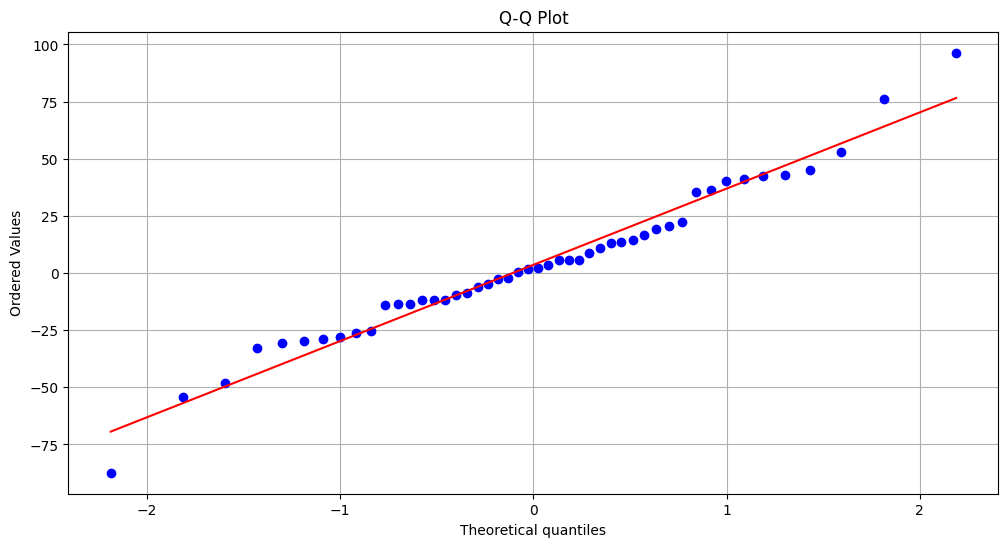

In [24]:
# 2. Q-Q Plot
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

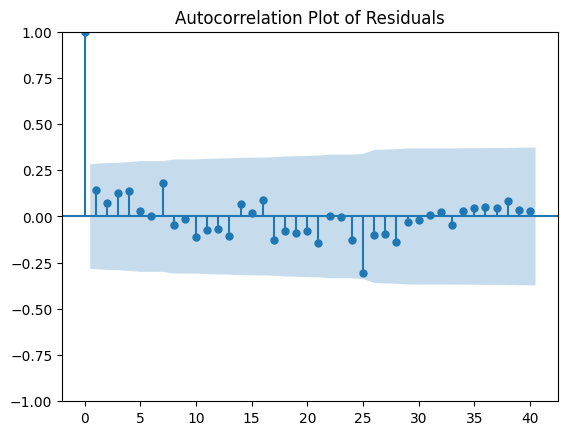

In [25]:
# 3. Autocorrelation Plot of Residuals
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('Autocorrelation Plot of Residuals')
plt.show()


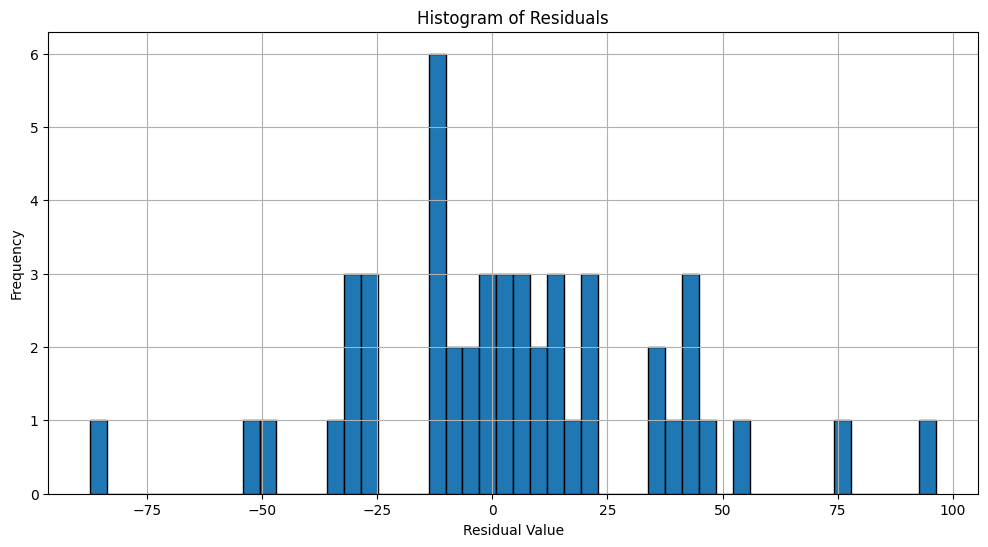

In [26]:
# 4. Histogram of Residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


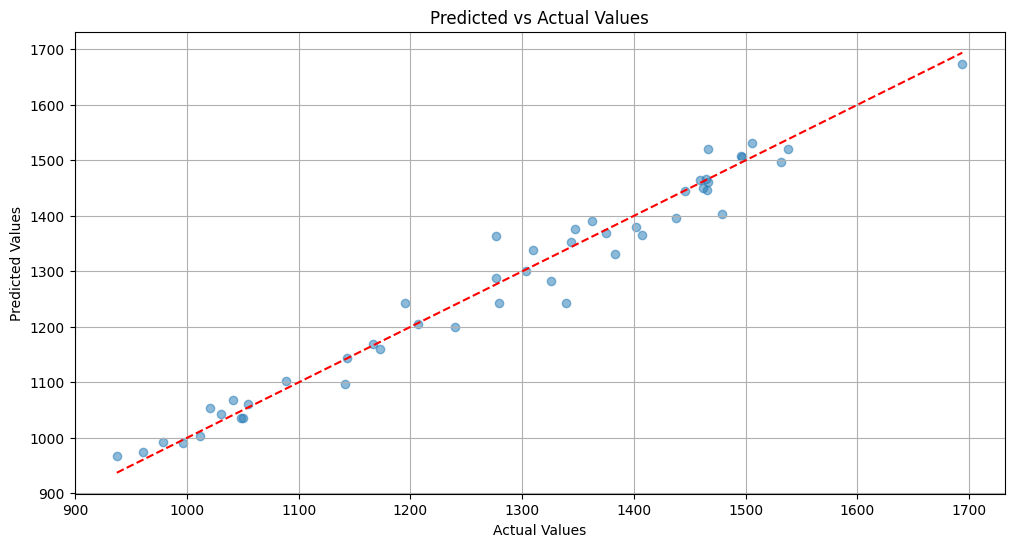

In [27]:
# 5. Predicted vs Actual Values
plt.figure(figsize=(12, 6))
plt.scatter(actuals_gold, predictions_gold, alpha=0.5)
plt.plot([min(actuals_gold), max(actuals_gold)], [min(actuals_gold), max(actuals_gold)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

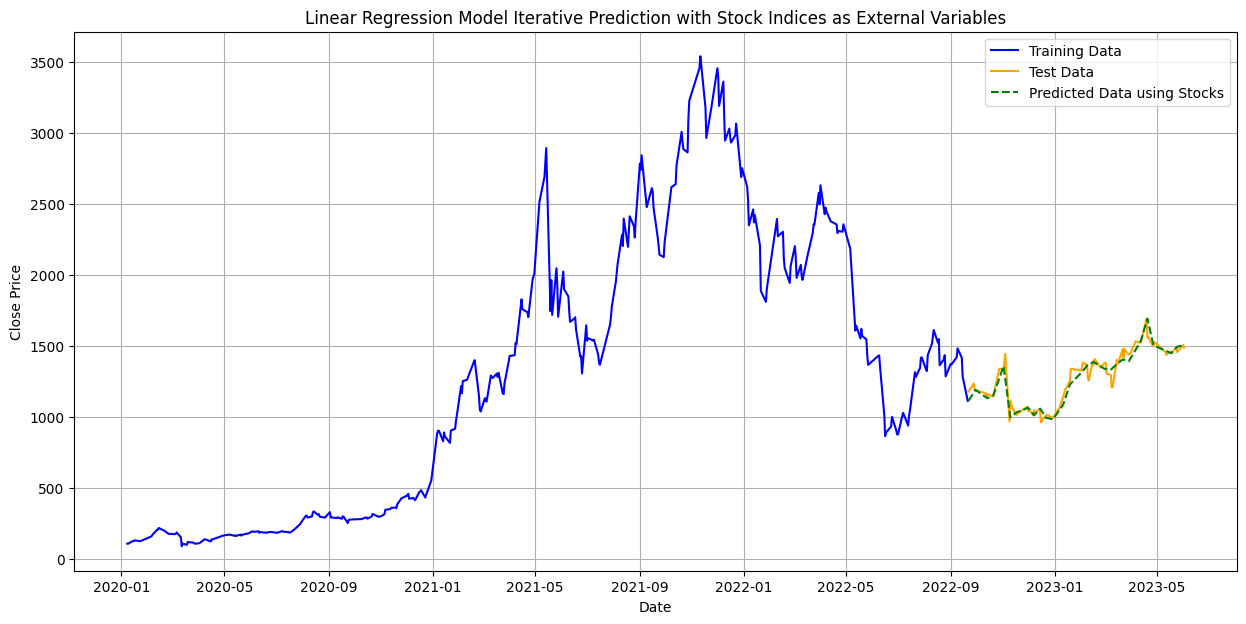

MAPE using Stocks: 2.79%
MSE using Stocks: 2308.61
RMSE using Stocks: 48.05
R^2 using Stocks: 0.93


In [28]:
# Reset data to the original dataframe
data = pd.read_csv('final_merged_eth_gold_global_data_v1.csv', parse_dates=['Date'], index_col='Date')

lagged_columns = ['Close', '^GSPC', '^NYA', '^DJI', '^IXIC']
data = create_lagged_features(data, lagged_columns)

# Splitting the data into 80% training and 20% testing
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Rolling forecast function using stock indices as external variables
def perform_rolling_forecast_with_stocks(train, test, step_size, num_lags=2):
    stock_indices = ['^GSPC', '^NYA', '^DJI', '^IXIC']
    return perform_rolling_forecast_linear_without_validation(train, test, step_size, num_lags, indices=stock_indices)

# Prediction and plotting code using stock indices
predictions_stocks, predicted_dates_stocks = perform_rolling_forecast_with_stocks(train_data, test_data, 3)
forecast_series_stocks = pd.Series(predictions_stocks, index=predicted_dates_stocks)

plt.figure(figsize=(15, 7))
plt.plot(train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Close'], label='Test Data', color='orange')
plt.plot(forecast_series_stocks, label='Predicted Data using Stocks', linestyle='--', color='green')
plt.legend()
plt.title("Linear Regression Model Iterative Prediction with Stock Indices as External Variables")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

# Calculate metrics on the test data
actuals_stocks = test_data['Close'].loc[predicted_dates_stocks]

mape_stocks = mean_absolute_percentage_error(actuals_stocks, predictions_stocks)
mse_stocks = mean_squared_error(actuals_stocks, predictions_stocks)
rmse_stocks = np.sqrt(mse_stocks)
r2_stocks = r2_score(actuals_stocks, predictions_stocks)

print(f"MAPE using Stocks: {mape_stocks:.2f}%")
print(f"MSE using Stocks: {mse_stocks:.2f}")
print(f"RMSE using Stocks: {rmse_stocks:.2f}")
print(f"R^2 using Stocks: {r2_stocks:.2f}")
